In [1]:
import torch
import math
from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [2]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [3]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [4]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [5]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [6]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [7]:
class SGD(Optimizer):
    # this is a SGD optimizer
    def __init__(self,lr,max_iter, parameters) :  
        super().__init__()
        self.eta = lr
        self.maxStep = max_iter 
        self.param = parameters
        self.number_step = 0

    def step(self): 
        if self.number_step <=self.maxStep:
            for parameter in self.param :
                parameter.data = parameter.data - self.eta * parameter.grad
            self.number_step = self.number_step + 1
        return self.param

In [8]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [9]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
    

In [10]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    #I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/self.x.shape[1]

In [11]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

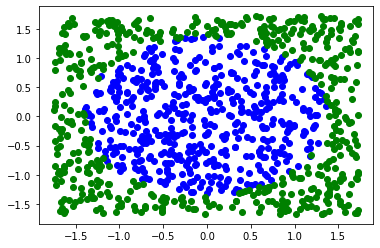

In [12]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0, 1)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
input_data, output_data=generate_disc_set(1000)
output_data=1-output_data
input_data-=input_data.mean(0)
input_data/=input_data.std(0)
import matplotlib.pyplot as plt
plt.plot(input_data[:,0][output_data==1],input_data[:,1][output_data==1],'bo')
plt.plot(input_data[:,0][output_data!=1],input_data[:,1][output_data!=1],'go')

In [35]:
#output_data = 2*output_data -1
print(input_data, input_data.shape, output_data.shape)

tensor([[-0.0231,  0.9301],
        [-1.4414, -1.2243],
        [-0.6799,  0.4758],
        ...,
        [-0.9371,  1.0547],
        [ 0.1064,  0.0881],
        [-0.5383,  1.2975]]) torch.Size([1000, 2]) tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,

In [14]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [21]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

optimizer = SGD(lr = 0.1,max_iter = 100, parameters = net.get_parameters())
n=100
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data[b:b+batch_size])
        l= loss.forward(predictions, output_data[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()

        net.backward(loss.backward())

        new_par = optimizer.step()
        net.set_parameters(new_par)

    print(t, '   MSE loss = ' , acc_loss.item())

correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

0    MSE loss =  2.6796183586120605
1    MSE loss =  2.272355794906616
2    MSE loss =  2.213056802749634
3    MSE loss =  2.1524927616119385
4    MSE loss =  2.088179349899292
5    MSE loss =  2.0194694995880127
6    MSE loss =  1.946194052696228
7    MSE loss =  1.8685392141342163
8    MSE loss =  1.7870380878448486
9    MSE loss =  1.7025556564331055
10    MSE loss =  1.6425442695617676
11    MSE loss =  1.6377484798431396
12    MSE loss =  1.6377484798431396
13    MSE loss =  1.6377484798431396
14    MSE loss =  1.6377484798431396
15    MSE loss =  1.6377484798431396
16    MSE loss =  1.6377484798431396
17    MSE loss =  1.6377484798431396
18    MSE loss =  1.6377484798431396
19    MSE loss =  1.6377484798431396
20    MSE loss =  1.6377484798431396
21    MSE loss =  1.6377484798431396
22    MSE loss =  1.6377484798431396
23    MSE loss =  1.6377484798431396
24    MSE loss =  1.6377484798431396
25    MSE loss =  1.6377484798431396
26    MSE loss =  1.6377484798431396
27    MSE loss 

In [40]:
correct_count=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[

tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[-1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
te

In [43]:
statements = torch.tensor(statements)
str((statements> 75).sum().item()/30.*100) + "% of number of predictions above 75%" 

'100.0% of number of predictions above 75%'

Correct predictions after 100 training steps: 96.0 %


In [41]:
#handmade sequential linear + relu 
statements = []
for i in range(30):
    print(i)
    linear1 = Linear(2, 25, True)
    linear2 = Linear(25,25,True)
    linear3 = Linear(25,1,True)
    sigma1 = Tanh()
    sigma2 = Tanh()
    sigma3 = Tanh()
    loss = MSE()

    net = Sequential([
        linear1, 
        sigma1 ,
        linear2,
        sigma2 ,
        linear3,
        sigma3 ,
    ])

    optimizer = SGD(lr = 0.1,max_iter = 100, parameters = net.get_parameters())
    n=100
    N=output_data.shape[0]
    batch_size = 100
    for t in range(n):
        acc_loss=0
        for b in range(0, N, batch_size):
            predictions = net.forward(input_data[b:b+batch_size])
            l= loss.forward(predictions, output_data[b:b+batch_size].unsqueeze(-1))
            acc_loss += l
            optimizer.zero_grad()

            net.backward(loss.backward())

            new_par = optimizer.step()
            net.set_parameters(new_par)

        #print(t, '   MSE loss = ' , acc_loss.item())

    correct_count=0
    for i in range(output_data.shape[0]):
            x=input_data[i]
            y=2*output_data[i]-1

            y_pred = net.forward(x.unsqueeze(0))
        
            correct = bool(y_pred.sign()*y)
            #print(y_pred.sign(), y, correct)
            if correct : correct_count += 1

    statements += [correct_count/N*100]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [15]:
statements = torch.tensor(statements)
str((statements> 75).sum().item()/30.*100) + "% of number of predictions above 75%" 

'100.0% of number of predictions above 75%'

In [16]:
statements

tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100.])

In [18]:
raise NowTheOldPart

NameError: name 'NowTheOldPart' is not defined

In [ ]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**3
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    for i in range(N):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

In [ ]:
correct_count=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')